In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

In [5]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [8]:
# Images: want smaller batch sizes (depends on computer, network; try smaller then go to larger)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [9]:
# First break down the model (later class will be built)
# Conv. layers
conv1 = nn.Conv2d(1,6,3,1)  # 1 input channel (1 greyscale channel); 6 filters (arbitrary output channels); 3x3 filter; 1 stepsize
# here could also be pooling layer, reducing the filter size
conv2 = nn.Conv2d(6,16,3,1)  # takes 6 filters from first layer; 16 filters (arbitrary)


In [10]:
for i, (X_train,y_train) in enumerate(train_data):
    break

In [16]:
x = X_train.view(1,1,28,28)  # ---> 4D batch of 1 image (and 1 colorchannel,...)
x.shape

torch.Size([1, 1, 28, 28])

In [17]:
# Pass through one conv layer
x = F.relu(conv1(x)) 

In [18]:
x.shape  # 1 image, 6 filters, lost information on borders

torch.Size([1, 6, 26, 26])

In [24]:
x = F.max_pool2d(x,2,2)  # downsampling /2

In [25]:
x.shape

torch.Size([1, 6, 13, 13])

In [26]:
x = F.relu(conv2(x))

In [27]:
x.shape

torch.Size([1, 16, 11, 11])

In [28]:
x = F.max_pool2d(x,2,2)

In [29]:
x.shape

torch.Size([1, 16, 5, 5])

In [32]:
# Flattend layer
x.view(-1,16*5*5).shape  # -1 changes batch size: keep that first dimension (normally batch of 10)

torch.Size([1, 400])

In [35]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)  # Pooling won't be layer, but function later
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)  # 120 arbitrary number of flattened neurons
        self.fc2 = nn.Linear(120,84)  # 84 arbitrary
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))  # pass through activation function
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))  # pass through activation function
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)  # -1 so we can vary the batch size
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        #Last activation function: softmax
        return F.log_softmax(X,dim=1)
        

In [47]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
for param in model.parameters():
    print(param.numel())  # number of elements

54
6
864
16
48000
120
10080
84
840
10


In [49]:
# total of 60074, nearly half of ANN

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [51]:
import time
start_time = time.time()


# TRACKERS
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# LOOP EPOCHS
for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0

    # TRAIN
    
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train)  # Don't need to flatten cause we use 2d data
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()  # sum of booleans, True->1, False->0
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:  # that's why we made b+=1
            print(f'EPOCH: {i} BATCH: {b} LOSS: {loss.item()}')
            
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
    
    # TEST
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'Training took {total_time/60} minutes')

EPOCH: 0 BATCH: 600 LOSS: 0.040556252002716064
EPOCH: 0 BATCH: 1200 LOSS: 0.08253474533557892
EPOCH: 0 BATCH: 1800 LOSS: 0.36018985509872437
EPOCH: 0 BATCH: 2400 LOSS: 0.01818694919347763
EPOCH: 0 BATCH: 3000 LOSS: 0.00846516527235508
EPOCH: 0 BATCH: 3600 LOSS: 0.001142998575232923
EPOCH: 0 BATCH: 4200 LOSS: 0.624707818031311
EPOCH: 0 BATCH: 4800 LOSS: 0.046218063682317734
EPOCH: 0 BATCH: 5400 LOSS: 0.00839207973331213
EPOCH: 0 BATCH: 6000 LOSS: 0.044792745262384415
EPOCH: 1 BATCH: 600 LOSS: 0.003464172128587961
EPOCH: 1 BATCH: 1200 LOSS: 0.048956435173749924
EPOCH: 1 BATCH: 1800 LOSS: 0.000778083922341466
EPOCH: 1 BATCH: 2400 LOSS: 0.04166005551815033
EPOCH: 1 BATCH: 3000 LOSS: 0.19562456011772156
EPOCH: 1 BATCH: 3600 LOSS: 0.002942086197435856
EPOCH: 1 BATCH: 4200 LOSS: 0.0005433653714135289
EPOCH: 1 BATCH: 4800 LOSS: 0.0005624962504953146
EPOCH: 1 BATCH: 5400 LOSS: 0.00030035508098080754
EPOCH: 1 BATCH: 6000 LOSS: 0.03586563095450401
EPOCH: 2 BATCH: 600 LOSS: 0.002943187253549695
EP

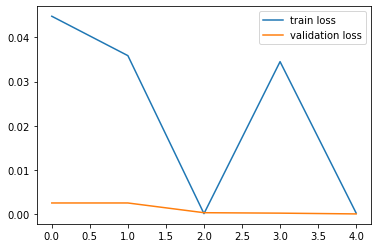

In [53]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='validation loss')
plt.legend()

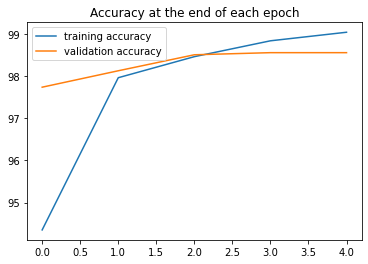

In [54]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [55]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [56]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [57]:
correct.item()/len(test_data)

0.9856

In [58]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    2    0    0    2    3    0    2    0]
 [   0 1135    4    1    1    0    4    7    0    3]
 [   2    0 1014    0    0    0    1    3    1    1]
 [   0    0    0 1000    0   17    0    0    1    0]
 [   0    0    1    0  979    0    2    0    1   16]
 [   0    0    0    1    0  859    0    0    1    2]
 [   3    0    0    0    0    3  945    0    0    0]
 [   1    0   11    5    0    1    0 1016    1    5]
 [   1    0    0    2    0    4    3    1  965   11]
 [   1    0    0    1    2    6    0    1    2  971]]


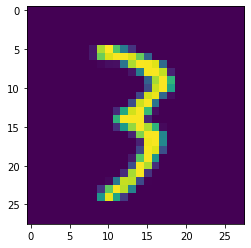

In [70]:
# Single image
plt.imshow(test_data[213][0].reshape(28,28))

In [73]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[213][0].reshape(1,1,28,28))

In [74]:
new_prediction.argmax()

tensor(3)